# The final training on the full food101 dataset

Primarly this notebook was supposed to look a little different, however I was shocked when the model didn't train well after all this hyperparameter tuning. It had about 50% accuracy on train set and 60-66% on validation set, across all the epochs. I knew that this is far too bad for a model that had over 84% top1 accuracy on IMAGENET, therefore I started experimenting to find out what is the reason. I have done it in a less structured and well thought way to find the issue ASAP, I also used A100 GPU through google collab as it is 5x faster than mine GPU. After about 3 hours of experiments here are the conclusions I came up with:
- the source of the problem are batch_norm layers in the "features" part of EffNetV2-S, in brief in .train() mode they normalise inputs with their own normalization stats, and in .eval() mode they use running statistics accumulated in the pre-training on IMAGENET, which fit better to the rest of the model. Therefore I will use the model in .eval() mode both in training and in evaluation.
- The model gets better results in validation set, because it is over-regularized and because of that I won't be using weight decay, as it makes things worse.
- Despite over-regularization, data augmentation has a very little but positive impact on the training, therefore I will use it.
- Learning rate **0.15** still proves to work very well.

## Data setup

In [1]:
import torch
import torchvision
import os
from torch import nn
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torch.utils.tensorboard.writer import SummaryWriter

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

the model will be permanently in .eval() mode, therefore dropout would be just a constant scaling factor, so it is not needed anymore

In [3]:
def create_effnet_v2s():
    weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
    model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)
    
    for p in model.features.parameters():
        p.requires_grad = False
    
    model.classifier = nn.Linear(1280, 101).to(device)
    
    return model

In [4]:
transform = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT.transforms()
transform_aug = v2.Compose([
    v2.TrivialAugmentWide(),
    v2.Resize((384, 384)),
    v2.PILToTensor(),
    v2.ToDtype(dtype=torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
num_workers = os.cpu_count() // 2
num_workers

6

In [6]:
train_ds = torchvision.datasets.Food101("data", split="train", transform=transform_aug, download=True)
valid_ds = torchvision.datasets.Food101("data", split="test", transform=transform)

train_dl = DataLoader(train_ds,
                      batch_size=32,
                      shuffle=True,
                      num_workers=num_workers,
                      pin_memory=True)

valid_dl = DataLoader(valid_ds,
                      batch_size=32,
                      shuffle=False,
                      num_workers=num_workers,
                      pin_memory=True)

## Train function adjusted

In [7]:
from engine import valid_step
from tqdm.auto import tqdm
from torchmetrics import Accuracy
from torch.optim.lr_scheduler import OneCycleLR

In [8]:
def train_step(model, dataloader, optimizer, scheduler, loss_fn, device, accuracy):
    avg_accuracy = 0
    avg_loss = 0
    model.eval()

    # Necessary for dataloader to work with tqdm without errors, tqdm interferes with dataloader workers shutdown process,
    # therefore I separated them
    dl_iterator = iter(dataloader)
    for _ in tqdm(range(len(dataloader)), desc="Training", leave=False):
        batch, target = next(dl_iterator)
        batch, target = batch.to(device), target.to(device)
        
        logits = model(batch)
        loss = loss_fn(logits, target)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

        avg_loss += loss.item()
        avg_accuracy += accuracy(logits, target).item()

    avg_loss /= len(dataloader)
    avg_accuracy /= len(dataloader)
    return avg_loss, avg_accuracy

In [9]:
def train_final(model, train_dl, valid_dl, optimizer, loss_fn, epochs, writer=None):
    device = next(iter(model.parameters())).device
    acc_fn = Accuracy(task="multiclass", num_classes=len(train_dl.dataset.classes)).to(device)
    max_lr = optimizer.defaults['lr']
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(train_dl), epochs=epochs)
    best_valid_acc = 0

    for epoch in tqdm(range(epochs), desc="Epochs"):
        train_loss, train_acc = train_step(
            model,
            train_dl,
            optimizer,
            scheduler,
            loss_fn,
            device,
            acc_fn
        )

        valid_loss, valid_acc = valid_step(
            model,
            valid_dl,
            loss_fn,
            device,
            acc_fn
        )

        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            torch.save(model.state_dict(), f"models/effnet_v2s_epoch_{epoch+1}")

        if writer is not None:
            writer.add_scalar("train_loss", train_loss, global_step=epoch)
            writer.add_scalar("validation_loss", valid_loss, global_step=epoch)
            
            writer.add_scalar("train_accuracy", train_acc, global_step=epoch)
            writer.add_scalar("validation_accuracy", valid_acc, global_step=epoch)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"valid_loss: {valid_loss:.4f} | "
            f"valid_acc: {valid_acc:.4f}"
        )

## Final Training

In [10]:
%%time
model = create_effnet_v2s()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.15, momentum=0.9)

writer = SummaryWriter(log_dir=f"tensorboard_stats/final_training")
    
train_final(model, train_dl, valid_dl, optimizer, loss_fn, epochs=25, writer=writer)

Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9199 | train_acc: 0.5357 | valid_loss: 1.2245 | valid_acc: 0.6782


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 1.3909 | train_acc: 0.6348 | valid_loss: 1.0548 | valid_acc: 0.7115


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 1.2723 | train_acc: 0.6637 | valid_loss: 1.0065 | valid_acc: 0.7206


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 1.2143 | train_acc: 0.6761 | valid_loss: 0.9834 | valid_acc: 0.7301


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 1.1697 | train_acc: 0.6878 | valid_loss: 0.9895 | valid_acc: 0.7305


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 6 | train_loss: 1.1303 | train_acc: 0.6985 | valid_loss: 1.0042 | valid_acc: 0.7296


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 7 | train_loss: 1.0943 | train_acc: 0.7076 | valid_loss: 0.9764 | valid_acc: 0.7374


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 8 | train_loss: 1.0596 | train_acc: 0.7164 | valid_loss: 0.9493 | valid_acc: 0.7477


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 9 | train_loss: 1.0186 | train_acc: 0.7246 | valid_loss: 0.9488 | valid_acc: 0.7451


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 0.9912 | train_acc: 0.7338 | valid_loss: 0.9566 | valid_acc: 0.7482


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 11 | train_loss: 0.9604 | train_acc: 0.7402 | valid_loss: 0.9702 | valid_acc: 0.7419


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 12 | train_loss: 0.9309 | train_acc: 0.7462 | valid_loss: 0.9533 | valid_acc: 0.7474


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 13 | train_loss: 0.9116 | train_acc: 0.7497 | valid_loss: 0.9244 | valid_acc: 0.7539


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 14 | train_loss: 0.8876 | train_acc: 0.7571 | valid_loss: 0.9151 | valid_acc: 0.7561


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 15 | train_loss: 0.8663 | train_acc: 0.7623 | valid_loss: 0.8925 | valid_acc: 0.7628


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 16 | train_loss: 0.8335 | train_acc: 0.7692 | valid_loss: 0.9001 | valid_acc: 0.7598


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 17 | train_loss: 0.8091 | train_acc: 0.7754 | valid_loss: 0.8925 | valid_acc: 0.7626


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 18 | train_loss: 0.7805 | train_acc: 0.7827 | valid_loss: 0.8870 | valid_acc: 0.7613


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 19 | train_loss: 0.7521 | train_acc: 0.7893 | valid_loss: 0.8585 | valid_acc: 0.7691


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 20 | train_loss: 0.7264 | train_acc: 0.7972 | valid_loss: 0.8355 | valid_acc: 0.7759


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 21 | train_loss: 0.6980 | train_acc: 0.8065 | valid_loss: 0.8199 | valid_acc: 0.7782


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 22 | train_loss: 0.6666 | train_acc: 0.8163 | valid_loss: 0.8101 | valid_acc: 0.7792


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 23 | train_loss: 0.6469 | train_acc: 0.8227 | valid_loss: 0.8009 | valid_acc: 0.7823


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 24 | train_loss: 0.6273 | train_acc: 0.8281 | valid_loss: 0.7913 | valid_acc: 0.7840


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 25 | train_loss: 0.6216 | train_acc: 0.8310 | valid_loss: 0.7908 | valid_acc: 0.7842
CPU times: user 5h 22min 45s, sys: 25min 1s, total: 5h 47min 47s
Wall time: 5h 15min 7s


I have got some thoughts about this:
- I have got simillar accuracy on validation set just after 5 epochs when I was testing stuff. Therefore I will try to apply cosine annealing with warmth restarts, as I believe it fits longer trainings better
- It seems that a proper weight decay might be beneficial here, as even though the results are fine, the model is overfitting (just a little), I will try with the value I came up in the previous notebook, although according to my methods it may be too small as after setting model on 20% of data on .eval() mode, the weight decay I used there was not enough to stop it from overfitting.

## Final Training II

First I will demonstrate my scheduler, it needs the training loop to be redefined

In [10]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt

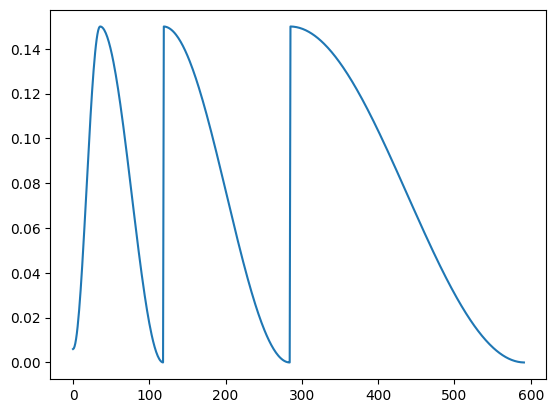

In [18]:
model = create_effnet_v2s()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.15, momentum=0.9, weight_decay=1.4e-4)
scheduler = OneCycleLR(optimizer, max_lr=0.15, steps_per_epoch=len(train_dl), epochs=5)

lrs = []
epoch = -1
for i in range(25*len(train_dl)):
    if i % len(train_dl) == 0:
        epoch += 1
        if epoch == 5:
            for param_group in optimizer.param_groups:
                param_group['lr'] = optimizer.defaults['lr']
                
            scheduler = CosineAnnealingLR(optimizer, len(train_dl) * 7)
        elif epoch == 12:
            for param_group in optimizer.param_groups:
                param_group['lr'] = optimizer.defaults['lr']
                
            scheduler = CosineAnnealingLR(optimizer, len(train_dl) * 13)

    lrs.append(scheduler.get_last_lr())
    scheduler.step()

lrs = lrs[::100]
plt.figure()
plt.plot(lrs)

In [13]:
def train_final_II(model, train_dl, valid_dl, optimizer, loss_fn, writer=None):
    device = next(iter(model.parameters())).device
    acc_fn = Accuracy(task="multiclass", num_classes=len(train_dl.dataset.classes)).to(device)
    max_lr = optimizer.defaults['lr']
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(train_dl), epochs=5)
    best_valid_acc = 0.7842

    for epoch in tqdm(range(25), desc="Epochs"):
        if epoch == 5:
            for param_group in optimizer.param_groups:
                param_group['lr'] = optimizer.defaults['lr']
                
            scheduler = CosineAnnealingLR(optimizer, len(train_dl) * 7)
        elif epoch == 12:
            for param_group in optimizer.param_groups:
                param_group['lr'] = optimizer.defaults['lr']
                
            scheduler = CosineAnnealingLR(optimizer, len(train_dl) * 13)
                
        train_loss, train_acc = train_step(
            model,
            train_dl,
            optimizer,
            scheduler,
            loss_fn,
            device,
            acc_fn
        )

        valid_loss, valid_acc = valid_step(
            model,
            valid_dl,
            loss_fn,
            device,
            acc_fn
        )

        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            torch.save(model.state_dict(), f"models/effnet_v2s_epoch_{epoch+1}_II")
        
        # I should have done the same adjustment for the first final training writer, but I forgot :(
        if writer is not None:
            writer.add_scalars("Loss", {"train_loss": train_loss, "validation_loss": valid_loss}, global_step=epoch)
            writer.add_scalars("Accuracy", {"train_accuracy": train_acc, "validation_accuracy": valid_acc}, global_step=epoch)
            
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"valid_loss: {valid_loss:.4f} | "
            f"valid_acc: {valid_acc:.4f}"
        )

In [14]:
%%time
model = create_effnet_v2s()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.15, momentum=0.9, weight_decay=1.4e-4)

writer = SummaryWriter(log_dir=f"tensorboard_stats/final_training_II")
    
train_final_II(model, train_dl, valid_dl, optimizer, loss_fn, writer=writer)

Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8582 | train_acc: 0.5392 | valid_loss: 1.1987 | valid_acc: 0.6730


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 1.4233 | train_acc: 0.6275 | valid_loss: 1.0846 | valid_acc: 0.7006


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 1.2838 | train_acc: 0.6592 | valid_loss: 1.0355 | valid_acc: 0.7153


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 1.1507 | train_acc: 0.6920 | valid_loss: 0.9128 | valid_acc: 0.7492


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 1.0024 | train_acc: 0.7350 | valid_loss: 0.8484 | valid_acc: 0.7744


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 6 | train_loss: 2.2524 | train_acc: 0.5546 | valid_loss: 1.8098 | valid_acc: 0.6301


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 7 | train_loss: 2.0642 | train_acc: 0.5778 | valid_loss: 1.5959 | valid_acc: 0.6506


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 8 | train_loss: 1.7294 | train_acc: 0.6051 | valid_loss: 1.3168 | valid_acc: 0.6648


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 9 | train_loss: 1.4042 | train_acc: 0.6438 | valid_loss: 1.0995 | valid_acc: 0.7023


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 1.1592 | train_acc: 0.6889 | valid_loss: 0.9184 | valid_acc: 0.7502


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 11 | train_loss: 0.9973 | train_acc: 0.7311 | valid_loss: 0.8463 | valid_acc: 0.7701


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 12 | train_loss: 0.9129 | train_acc: 0.7627 | valid_loss: 0.8281 | valid_acc: 0.7775


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 13 | train_loss: 2.2489 | train_acc: 0.5557 | valid_loss: 1.8980 | valid_acc: 0.6207


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 14 | train_loss: 2.1917 | train_acc: 0.5679 | valid_loss: 1.8335 | valid_acc: 0.6027


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 15 | train_loss: 2.0824 | train_acc: 0.5747 | valid_loss: 1.7003 | valid_acc: 0.6343


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 16 | train_loss: 1.9345 | train_acc: 0.5852 | valid_loss: 1.4875 | valid_acc: 0.6555


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 17 | train_loss: 1.7492 | train_acc: 0.6013 | valid_loss: 1.3279 | valid_acc: 0.6739


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 18 | train_loss: 1.5851 | train_acc: 0.6191 | valid_loss: 1.2521 | valid_acc: 0.6775


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 19 | train_loss: 1.4075 | train_acc: 0.6406 | valid_loss: 1.0551 | valid_acc: 0.7122


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 20 | train_loss: 1.2523 | train_acc: 0.6668 | valid_loss: 1.0377 | valid_acc: 0.7092


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 21 | train_loss: 1.1362 | train_acc: 0.6921 | valid_loss: 0.9316 | valid_acc: 0.7452


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 22 | train_loss: 1.0399 | train_acc: 0.7191 | valid_loss: 0.8788 | valid_acc: 0.7602


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 23 | train_loss: 0.9739 | train_acc: 0.7407 | valid_loss: 0.8541 | valid_acc: 0.7679


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 24 | train_loss: 0.9263 | train_acc: 0.7568 | valid_loss: 0.8338 | valid_acc: 0.7752


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 25 | train_loss: 0.9046 | train_acc: 0.7653 | valid_loss: 0.8296 | valid_acc: 0.7774
CPU times: user 5h 21min 29s, sys: 26min 54s, total: 5h 48min 23s
Wall time: 5h 13min 49s


I feel like the restarts dirupt the training too much, I will try again with decreasing intensity of restarts, and smaller weight decay as regularization was too big here

## Final Training III

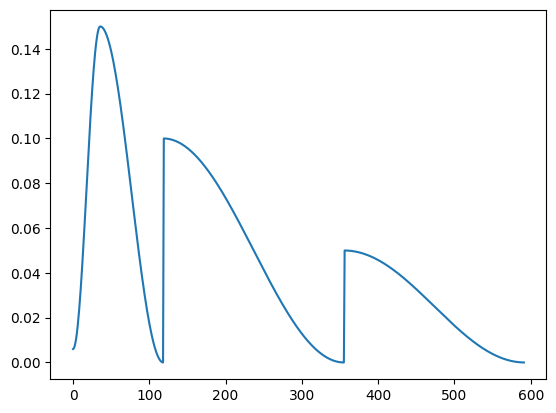

In [20]:
model = create_effnet_v2s()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.15, momentum=0.9, weight_decay=1e-5)
scheduler = OneCycleLR(optimizer, max_lr=0.15, steps_per_epoch=len(train_dl), epochs=5)

lrs = []
epoch = -1
for i in range(25*len(train_dl)):
    if i % len(train_dl) == 0:
        epoch += 1
        if epoch == 5:
            for param_group in optimizer.param_groups:
                param_group['lr'] = optimizer.defaults['lr'] * 2 / 3
                
            scheduler = CosineAnnealingLR(optimizer, len(train_dl) * 10)
        elif epoch == 15:
            for param_group in optimizer.param_groups:
                param_group['lr'] = optimizer.defaults['lr'] / 3
                
            scheduler = CosineAnnealingLR(optimizer, len(train_dl) * 10)

    lrs.append(scheduler.get_last_lr())
    scheduler.step()

lrs = lrs[::100]
plt.figure()
plt.plot(lrs)

In [22]:
def train_final_III(model, train_dl, valid_dl, optimizer, loss_fn, writer=None):
    device = next(iter(model.parameters())).device
    acc_fn = Accuracy(task="multiclass", num_classes=len(train_dl.dataset.classes)).to(device)
    max_lr = optimizer.defaults['lr']
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(train_dl), epochs=5)
    best_valid_acc = 0.7842

    for epoch in tqdm(range(25), desc="Epochs"):
        if epoch == 5:
            for param_group in optimizer.param_groups:
                param_group['lr'] = optimizer.defaults['lr'] * 2 / 3
                
            scheduler = CosineAnnealingLR(optimizer, len(train_dl) * 10)
        elif epoch == 15:
            for param_group in optimizer.param_groups:
                param_group['lr'] = optimizer.defaults['lr'] / 3
                
            scheduler = CosineAnnealingLR(optimizer, len(train_dl) * 10)
                
        train_loss, train_acc = train_step(
            model,
            train_dl,
            optimizer,
            scheduler,
            loss_fn,
            device,
            acc_fn
        )

        valid_loss, valid_acc = valid_step(
            model,
            valid_dl,
            loss_fn,
            device,
            acc_fn
        )

        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            torch.save(model.state_dict(), f"models/effnet_v2s_epoch_{epoch+1}_III")
        
        # I should have done the same adjustment for the first final training writer, but I forgot :(
        if writer is not None:
            writer.add_scalars("Loss", {"train_loss": train_loss, "validation_loss": valid_loss}, global_step=epoch)
            writer.add_scalars("Accuracy", {"train_accuracy": train_acc, "validation_accuracy": valid_acc}, global_step=epoch)
            
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"valid_loss: {valid_loss:.4f} | "
            f"valid_acc: {valid_acc:.4f}"
        )

In [23]:
%%time
model = create_effnet_v2s()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.15, momentum=0.9, weight_decay=1e-5)

writer = SummaryWriter(log_dir=f"tensorboard_stats/final_training_III")
    
train_final_III(model, train_dl, valid_dl, optimizer, loss_fn, writer=writer)

Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8484 | train_acc: 0.5404 | valid_loss: 1.1936 | valid_acc: 0.6767


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 1.3907 | train_acc: 0.6380 | valid_loss: 1.0446 | valid_acc: 0.7135


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 1.2259 | train_acc: 0.6760 | valid_loss: 0.9680 | valid_acc: 0.7345


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 1.0661 | train_acc: 0.7148 | valid_loss: 0.8578 | valid_acc: 0.7662


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.9074 | train_acc: 0.7565 | valid_loss: 0.8042 | valid_acc: 0.7793


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 6 | train_loss: 1.5313 | train_acc: 0.6384 | valid_loss: 1.4639 | valid_acc: 0.6779


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 7 | train_loss: 1.4329 | train_acc: 0.6653 | valid_loss: 1.2737 | valid_acc: 0.6930


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 8 | train_loss: 1.3026 | train_acc: 0.6856 | valid_loss: 1.1358 | valid_acc: 0.7227


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 9 | train_loss: 1.1499 | train_acc: 0.7088 | valid_loss: 1.0384 | valid_acc: 0.7386


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 1.0143 | train_acc: 0.7340 | valid_loss: 0.9695 | valid_acc: 0.7480


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 11 | train_loss: 0.8942 | train_acc: 0.7573 | valid_loss: 0.8972 | valid_acc: 0.7598


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 12 | train_loss: 0.8060 | train_acc: 0.7790 | valid_loss: 0.8485 | valid_acc: 0.7687


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 13 | train_loss: 0.7370 | train_acc: 0.7969 | valid_loss: 0.8074 | valid_acc: 0.7806


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 14 | train_loss: 0.6965 | train_acc: 0.8102 | valid_loss: 0.7924 | valid_acc: 0.7843


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 15 | train_loss: 0.6703 | train_acc: 0.8177 | valid_loss: 0.7882 | valid_acc: 0.7845


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 16 | train_loss: 0.8911 | train_acc: 0.7560 | valid_loss: 0.9273 | valid_acc: 0.7530


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 17 | train_loss: 0.8867 | train_acc: 0.7570 | valid_loss: 0.9084 | valid_acc: 0.7585


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 18 | train_loss: 0.8483 | train_acc: 0.7663 | valid_loss: 0.8986 | valid_acc: 0.7566


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 19 | train_loss: 0.8051 | train_acc: 0.7767 | valid_loss: 0.8705 | valid_acc: 0.7645


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 20 | train_loss: 0.7735 | train_acc: 0.7859 | valid_loss: 0.8424 | valid_acc: 0.7722


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 21 | train_loss: 0.7275 | train_acc: 0.7973 | valid_loss: 0.8163 | valid_acc: 0.7778


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 22 | train_loss: 0.6936 | train_acc: 0.8080 | valid_loss: 0.8004 | valid_acc: 0.7814


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 23 | train_loss: 0.6649 | train_acc: 0.8188 | valid_loss: 0.7899 | valid_acc: 0.7832


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 24 | train_loss: 0.6465 | train_acc: 0.8237 | valid_loss: 0.7831 | valid_acc: 0.7873


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Validation:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch: 25 | train_loss: 0.6347 | train_acc: 0.8274 | valid_loss: 0.7818 | valid_acc: 0.7869
CPU times: user 5h 22min 10s, sys: 27min 13s, total: 5h 49min 24s
Wall time: 5h 14min 27s


I couldn't have reached 79% accuracy, the next step would be either to find an optimal weight decay, that would allow to reach 79% accuracy, or even better to unfreeze some more layers, however I will leave it as it is.

## EffNetV2-S on Food101 20% with batch_norm layers correctly utilised

For the context, here are the results achieved with the same hyperparameters, but with batch_norm layers in .train() mode during training:

Epoch: 5 | train_loss: 1.6665 | train_acc: 0.5904 | valid_loss: 1.7158 | valid_acc: 0.5692

In [46]:
from torchvision.datasets import ImageFolder

In [47]:
def train_20p(model, train_dl, valid_dl, optimizer, loss_fn, epochs):
    device = next(iter(model.parameters())).device
    acc_fn = Accuracy(task="multiclass", num_classes=len(train_dl.dataset.classes)).to(device)
    max_lr = optimizer.defaults['lr']
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(train_dl), epochs=epochs)

    for epoch in tqdm(range(epochs), desc="Epochs"):
        train_loss, train_acc = train_step(
            model,
            train_dl,
            optimizer,
            scheduler,
            loss_fn,
            device,
            acc_fn
        )

        valid_loss, valid_acc = valid_step(
            model,
            valid_dl,
            loss_fn,
            device,
            acc_fn
        )

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"valid_loss: {valid_loss:.4f} | "
            f"valid_acc: {valid_acc:.4f}"
        )

In [48]:
train_ds_small = ImageFolder("data/food101_20_percent/train", transform=transform_aug)
valid_ds_small = ImageFolder("data/food101_20_percent/valid", transform=transform)

train_dl_small = DataLoader(train_ds_small,
                      batch_size=32,
                      shuffle=True,
                      num_workers=num_workers,
                      pin_memory=True)

valid_dl_small = DataLoader(valid_ds_small,
                      batch_size=32,
                      shuffle=False,
                      num_workers=num_workers,
                      pin_memory=True)

In [49]:
model = create_effnet_v2s()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.15, momentum=0.9, weight_decay=7e-4)
    
train_20p(model, train_dl_small, valid_dl_small, optimizer, loss_fn, epochs=5)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.4837 | train_acc: 0.4191 | valid_loss: 1.7277 | valid_acc: 0.5400


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 1.5962 | train_acc: 0.5760 | valid_loss: 1.5448 | valid_acc: 0.5927


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 1.3758 | train_acc: 0.6324 | valid_loss: 1.4636 | valid_acc: 0.6150


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 1.2220 | train_acc: 0.6777 | valid_loss: 1.3461 | valid_acc: 0.6454


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 1.0462 | train_acc: 0.7363 | valid_loss: 1.2901 | valid_acc: 0.6689


As I thought the results are much better also on the 20% subset of the full food101.

## EffNet_B5 vs EffNetV2-S revenge

The battle between those 2 architectures needs to be repeated, as the power of EffNetV2-S was weakened, by the poor utilization of batch_norm layers, actually the same could be said about EffNet_B5 as it also has batch_norm layers. Although they may were weakened equally, it is quite unlikely, therefore the experiment has to be repeated

In [50]:
def create_effnetb5():
    weights = torchvision.models.EfficientNet_B5_Weights.DEFAULT
    model = torchvision.models.efficientnet_b5(weights=weights).to(device)
    
    for p in model.features.parameters():
        p.requires_grad = False
    
    model.classifier = nn.Linear(2048, 101).to(device)
    
    return model

In [51]:
transform_b5 = torchvision.models.EfficientNet_B5_Weights.DEFAULT.transforms()
transform_v2s = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT.transforms()

train_ds20p_b5 = ImageFolder("data/food101_20_percent/train", transform=transform_b5)
valid_ds20p_b5 = ImageFolder("data/food101_20_percent/valid", transform=transform_b5)

train_ds20p_v2s = ImageFolder("data/food101_20_percent/train", transform=transform_v2s)
valid_ds20p_v2s = ImageFolder("data/food101_20_percent/valid", transform=transform_v2s)

In [52]:
train_dl_20p_b5 = DataLoader(train_ds20p_b5, 
                         batch_size=32,
                         shuffle=True,
                         num_workers=num_workers,
                         pin_memory=True)

valid_dl_20p_b5 = DataLoader(valid_ds20p_b5, 
                         batch_size=32,
                         shuffle=False,
                         num_workers=num_workers,
                         pin_memory=True)

train_dl_20p_v2s = DataLoader(train_ds20p_v2s, 
                         batch_size=32,
                         shuffle=True,
                         num_workers=num_workers,
                         pin_memory=True)

valid_dl_20p_v2s = DataLoader(valid_ds20p_v2s, 
                         batch_size=32,
                         shuffle=False,
                         num_workers=num_workers,
                         pin_memory=True)

In [53]:
model_names = ["EffNet_B5", "EffNetV2-S"]

In [54]:
experiment_number = 0
for model_name in model_names:
    experiment_number += 1
    print(f"[INFO] Experiment numer: {experiment_number}")
    print(f"[INFO] Model: {model_name}")
    
    if model_name == "EffNet_B5":
        model = create_effnetb5()
        train_dl = train_dl_20p_b5
        valid_dl = valid_dl_20p_b5
    else:
        model = create_effnet_v2s()
        train_dl = train_dl_20p_v2s
        valid_dl = valid_dl_20p_v2s

    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.005)
    loss_fn = nn.CrossEntropyLoss()
        
    train_20p(model, train_dl, valid_dl, optimizer, loss_fn, epochs=5)
        
    print("-"*50 + '\n')

[INFO] Experiment numer: 1
[INFO] Model: EffNet_B5


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.6222 | train_acc: 0.4624 | valid_loss: 1.4676 | valid_acc: 0.6093


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 1.2037 | train_acc: 0.6785 | valid_loss: 1.3273 | valid_acc: 0.6619


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.6944 | train_acc: 0.8088 | valid_loss: 1.2038 | valid_acc: 0.6883


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.3960 | train_acc: 0.9050 | valid_loss: 1.1311 | valid_acc: 0.7097


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.2728 | train_acc: 0.9518 | valid_loss: 1.1116 | valid_acc: 0.7155
--------------------------------------------------

[INFO] Experiment numer: 2
[INFO] Model: EffNetV2-S


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8595 | train_acc: 0.3876 | valid_loss: 1.7582 | valid_acc: 0.5334


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 1.4456 | train_acc: 0.6147 | valid_loss: 1.5163 | valid_acc: 0.6006


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 1.0014 | train_acc: 0.7249 | valid_loss: 1.3719 | valid_acc: 0.6396


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.7170 | train_acc: 0.8142 | valid_loss: 1.2836 | valid_acc: 0.6631


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.5823 | train_acc: 0.8646 | valid_loss: 1.2639 | valid_acc: 0.6704
--------------------------------------------------



Now both models are severely overfitting, especially B5. The gap between those 2 models has closed, still B5 seems to do better, but at the cost of **2.5x** longer train time. Adding weight decay and data augmentation to prevent overfitting would make the comparison more accurate, but at this point I will give up on it.

## Results of the final training

Let's visualise the final model predictions

In [24]:
from PIL import Image

In [26]:
!pwd

/home/vertex/Desktop/pytorch-deep-learning/extras/exercises


In [27]:
model = create_effnet_v2s()
model.load_state_dict(torch.load("best_model/effnet_v2s_epoch_24_III"))

/tmp/ipykernel_3024/3792846923.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model/effnet_v2s_epoch_24_III"))


<All keys matched successfully>

In [31]:
class_names = train_ds.classes

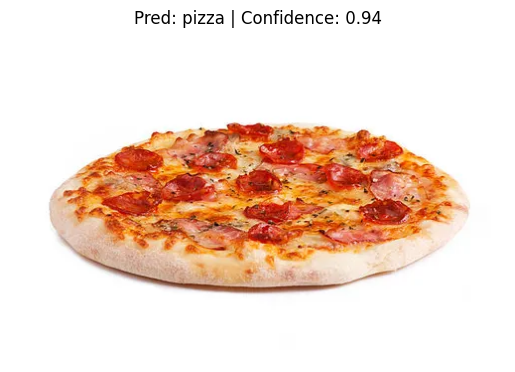

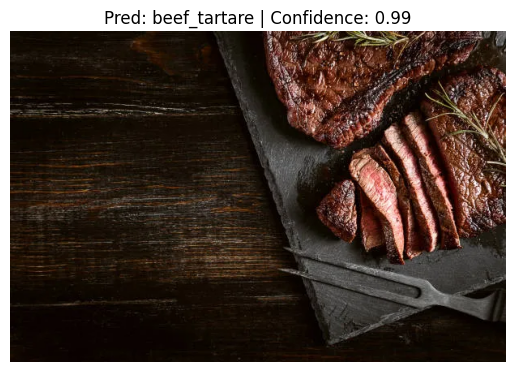

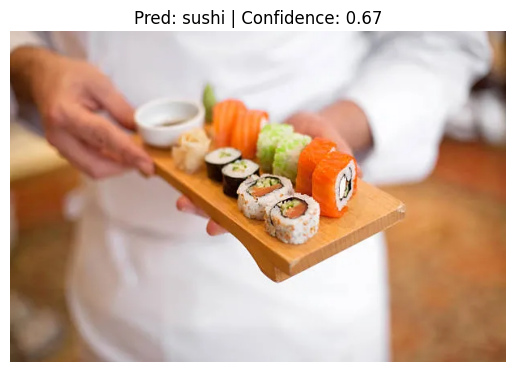

In [32]:
pizza = Image.open("data/pizza.jpg")
steak = Image.open("data/steak.jpg")
sushi = Image.open("data/sushi.jpg")

batch = [pizza, steak, sushi]
batch = [transform(b) for b in batch]
batch = torch.stack(batch).to(device)

model.eval()
with torch.inference_mode():
    logits = model(batch)
    preds = logits.argmax(dim=1)
    probs = logits.softmax(dim=1)

conf = probs[torch.arange(len(preds)), preds].cpu().numpy()
preds = [class_names[p] for p in preds]

plt.figure()
plt.imshow(pizza)
plt.title(f"Pred: {preds[0]} | Confidence: {conf[0]:.2f}")
plt.axis(False)
plt.show()

plt.figure()
plt.imshow(steak)
plt.title(f"Pred: {preds[1]} | Confidence: {conf[1]:.2f}")
plt.axis(False)
plt.show()

plt.figure()
plt.imshow(sushi)
plt.title(f"Pred: {preds[2]} | Confidence: {conf[2]:.2f}")
plt.axis(False)
plt.show()